In [105]:
#!pip install reverse_geocoder
#!pip install plotly_express

import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn

import plotly.graph_objects as go
import plotly_express as px

# Geocoding
import reverse_geocoder as rg

# Statistical analysis
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from scipy.stats import f_oneway
from scipy.stats import ttest_ind



# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Output
#  df_ts_complete: df with values where time series is complete
#  df_estimate: df where all time series values are NaN but there is an estimate
#  df_ts_incomplete: df with values where at least one of time series values is NaN
# 
# Reads global powerplant data data from CSV, drops irrelevant columns, splits df (see output), 
# and re-indexes df with gppdf_idnr as index
def read_clean_and_split():  
    df = pd.read_csv("data\global_power_plant_database.csv")
    df_all = df.drop(['country_long', 'url', 'geolocation_source', 'wepp_id'], axis=1)
    
    df_ts = (df_all.dropna(how='all', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
                      .set_index('gppd_idnr'))
    df_ts_complete = df_ts.dropna(how='any', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
    df_estimate = (df_all.dropna(how='any', subset=['estimated_generation_gwh'])
                   .set_index('gppd_idnr'))
    df_ts_incomplete = df_ts[df_ts[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].isnull().any(axis=1)]
    return df_all, df_ts_complete, df_ts_incomplete, df_estimate     

In [3]:
df_all, df_ts_complete, df_ts_incomplete, df_estimate = read_clean_and_split()
df_all.head()

country                                               name     gppd_idnr  \
0     AFG       Kajaki Hydroelectric Power Plant Afghanistan  GEODB0040538   
1     AFG      Mahipar Hydroelectric Power Plant Afghanistan  GEODB0040541   
2     AFG   Naghlu Dam Hydroelectric Power Plant Afghanistan  GEODB0040534   
3     AFG  Nangarhar (Darunta) Hydroelectric Power Plant ...  GEODB0040536   
4     AFG            Northwest Kabul Power Plant Afghanistan  GEODB0040540   

   capacity_mw  latitude  longitude primary_fuel other_fuel1 other_fuel2  \
0        33.00   32.3220    65.1190        Hydro         NaN         NaN   
1        66.00   34.5560    69.4787        Hydro         NaN         NaN   
2       100.00   34.6410    69.7170        Hydro         NaN         NaN   
3        11.55   34.4847    70.3633        Hydro         NaN         NaN   
4        42.00   34.5638    69.1134          Gas         NaN         NaN   

  other_fuel3  commissioning_year owner source  year_of_capacity_data  \
0         NaN                 NaN   NaN  GEODB                 2017.0   
1         NaN                 NaN   NaN  GEODB                 2017.0   
2         NaN                 NaN   NaN  GEODB                 2017.0   
3         NaN                 NaN   NaN  GEODB                 2017.0   
4         NaN                 NaN   NaN  GEODB                 2017.0   

   generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   generation_gwh_2016  generation_gwh_2017  estimated_generation_gwh  
0                  NaN                  NaN                       NaN  
1                  NaN                  NaN                       NaN  
2                  NaN                  NaN                       NaN  
3                  NaN                  NaN                       NaN  
4                  NaN                  NaN                       NaN

# 1. Analysis on full dataset
## 1.1. Comparison between different fuel types

In [4]:
# Group by the fuel type
fueltype = df_all.groupby("primary_fuel")
fueltype.describe()

capacity_mw                                             \
                     count         mean          std   min        25%   
primary_fuel                                                            
Biomass             1396.0    24.667408    39.970655   1.0     3.0000   
Coal                2390.0   836.619247   883.792022   1.2   200.0000   
Cogeneration          41.0    97.624390   283.717419   1.6     7.5000   
Gas                 3922.0   375.495683   562.794664   1.0    31.1250   
Geothermal           189.0    66.473810   114.770905   1.0    18.0000   
Hydro               7155.0   146.804321   549.433962   1.0     5.3000   
Nuclear              198.0  2069.832626  1304.270269  20.0  1100.0000   
Oil                 2290.0   114.565943   394.966198   1.0     2.5404   
Other                 44.0    85.399091   144.155122   4.5    17.5000   
Petcoke               13.0   192.082885   458.141449   4.7    27.3000   
Solar               5929.0    10.747651    26.418461   1.0     2.0000   
Storage               58.0     7.820690     9.682517   1.0     2.0000   
Waste               1087.0    13.898081    20.690791   1.0     2.3000   
Wave and Tidal        10.0    55.220000   101.440708   1.0     1.4000   
Wind                5188.0    46.299842   102.712898   1.0    10.0000   

                                            latitude             ...  \
                    50%       75%       max    count       mean  ...   
primary_fuel                                                     ...   
Biomass            9.95    29.175    528.00   1396.0  19.364704  ...   
Coal             600.00  1200.000   7000.00   2390.0  32.725796  ...   
Cogeneration      30.00    49.300   1404.00     41.0  38.124766  ...   
Gas              152.25   530.000   8865.00   3922.0  31.662952  ...   
Geothermal        30.00    77.000   1163.00    189.0  29.557186  ...   
Hydro             20.00    93.000  22500.00   7155.0  30.309767  ...   
Nuclear         1883.40  2665.025   8212.00    198.0  38.597543  ...   
Oil                9.20    50.000   6794.00   2290.0  14.116997  ...   
Other             40.00    98.625    845.26     44.0  38.899089  ...   
Petcoke           67.00   122.900   1707.30     13.0  31.472562  ...   
Solar              4.70     9.000    648.00   5929.0  40.678147  ...   
Storage            2.90    10.000     40.00     58.0  39.166022  ...   
Waste              4.90    15.250    160.90   1087.0  39.106433  ...   
Wave and Tidal     5.00    22.250    254.00     10.0  52.995930  ...   
Wind              26.00    49.000   6000.00   5188.0  36.618024  ...   

               generation_gwh_2017               estimated_generation_gwh  \
                               75%           max                    count   
primary_fuel                                                                
Biomass                 338.506503    831.165002                   1241.0   
Coal                   6262.190992  35116.000000                   1846.0   
Cogeneration            166.049000    564.213000                     11.0   
Gas                     530.573000  20515.369717                   2115.0   
Geothermal              303.664250   4667.659000                    127.0   
Hydro                   158.727375  20983.990000                   5438.0   
Nuclear               17592.001000  32340.138000                    128.0   
Oil                       0.732500   6972.247003                   1442.0   
Other                   128.024499    508.701000                     28.0   
Petcoke                 297.125749   5776.007940                      1.0   
Solar                     9.928000   1237.532000                   4567.0   
Storage                   0.056000     34.300000                      0.0   
Waste                    99.123750    928.862008                    538.0   
Wave and Tidal                 NaN           NaN                      0.0   
Wind                    374.916500   1972.964000                   4309.0   

                

**Interpretation:**

We can see that the power plants of some 'green' fuel types are numerous in numbers: Hydro (7155), Solar (5292), Wind (5188); and that the number of Gas (3922), Coal (2390) and Oil (2290) power plants is considerably lower. However, when looking at the mean capacities, we see that Nuclear (appr. 2070), Coal (appr. 873) and Gas (appr. 375) have much higher mean capacity than Hydro (appr. 147), Solar (appr. 11) and Wind (appr. 46). 

To investigate which fuel types are really resposnsible for the most energy output, it seems more logical to compare the total sum of capacities of all power plants of a particular fuel type (as we do not have reported values for actual energy outputs for some power plants).

In [5]:
#Green fuels = 1, non-green fuels = 0, other = 0 (other is also 0 for simplicity)
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], 0))

In [89]:
capacity = fueltype.agg(**{'capacity_sum': pd.NamedAgg(column='capacity_mw', aggfunc='sum')})
capacity = capacity.sort_values(by='capacity_sum', ascending = False)
capacity = capacity.reset_index()
capacity['is_green'] = capacity['primary_fuel'].apply(lambda x: green_map[x])
capacity

primary_fuel  capacity_sum  is_green
0             Coal  1.999520e+06         0
1              Gas  1.472694e+06         0
2            Hydro  1.050385e+06         1
3          Nuclear  4.098269e+05         1
4              Oil  2.623560e+05         0
5             Wind  2.402036e+05         1
6            Solar  6.372282e+04         1
7          Biomass  3.443570e+04         1
8            Waste  1.510721e+04         1
9       Geothermal  1.256355e+04         1
10    Cogeneration  4.002600e+03         1
11           Other  3.757560e+03         0
12         Petcoke  2.497077e+03         0
13  Wave and Tidal  5.522000e+02         1
14         Storage  4.536000e+02         1

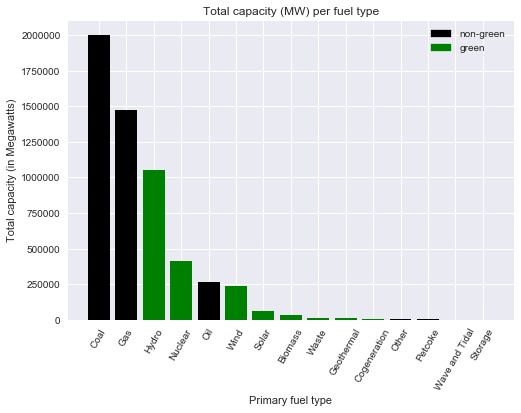

In [88]:
# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
plt.style.use('seaborn')
colors = {0:"black", 1:"green"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
c = capacity['is_green'].apply(lambda x: colors[x])
plt.bar(capacity['primary_fuel'], capacity['capacity_sum'], color=c, label=colors)
plt.xticks(rotation = 60)
plt.title("Total capacity (MW) per fuel type")
plt.xlabel("Primary fuel type")
plt.ylabel("Total capacity (in Megawatts)", rotation = 90)
plt.legend(handles, ["non-green", "green", "other"])
#plt.savefig(r'plots\tot_cpcty_p_fuel.svg')

**Interpretation:**
Not surprisingly, we see that the first two fuel types are Coal and Gas. However, Hydro also is in the top-three. Nuclear and Oil power plants also seem to be considerable energy producers.

## 1.2. Visualizing the data with Maps

Where are the powerplants located around the world? Let's create a map with points for each power plant.

In [8]:
color_dict = {'Solar':'#ffe119', 
          'Gas':'#e6194B', 
          'Oil':'#b15928', 
          'Wind':'#42d4f4', 
          'Hydro':'#4363d8', 
          'Coal':'#fdb462', 
          'Biomass':'#dcbeff', 
          'Waste':'#3cb44b', 
          'Cogeneration':'#d9d9d9', 
          'Geothermal':'#bc80bd', 
          'Nuclear':'#bfef45', 
          'Petcoke':'#ccebc5', 
          'Other':'#fffac8', 
          'Storage':'#469990'}

In [9]:
#Set show_slow_maps to True to show this plot
show_slow_maps = False
if(show_slow_maps):
    fig = px.scatter_geo(df_all,
                        lat=df_all["latitude"],
                        lon=df_all["longitude"],
                        hover_name=df_all["name"],
                        color = df_all["primary_fuel"],
                        color_discrete_map = color_dict,                       
                        title = "Location of Powerplants around the World"
                        )
    fig.show()
    #fig.write_html("plots/map_loc_pp_around_world.html")    

In [10]:
df_pf = (df_all.groupby(['country', 'primary_fuel'], as_index = False)[["capacity_mw"]].sum()
        .sort_values(['country','capacity_mw'], ascending = [True, False], ignore_index = True)
        .drop_duplicates(subset=['country'], keep='first', ignore_index = True))

In [11]:
#plots the countries based on the most used primary fuel types
fig = px.choropleth(df_pf, locations=df_pf["country"],
                    hover_name=df_pf["country"],
                    color = df_pf["primary_fuel"],
                    color_discrete_map = color_dict,
                    title = "Fuel with highest total capacity per country"
                   )
fig.show()
#fig.write_html("plots/map_fuel_highest_tot_capacity_per_country.html")

In [12]:
# Creates new column 'avg_annual_output' in df by
#  - copying estimated_generation_gwh in rows where it is not NaN
#  - averaging the time series in the remaining rows
def annual_output(df):
    df['avg_annual_output'] = df['estimated_generation_gwh']    
    idx = df.index[df['estimated_generation_gwh'].isna()].tolist()    
    df.loc[idx,'avg_annual_output'] = df[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].mean(axis=1)

In [13]:
annual_output(df_all)

In [14]:
df_pf2 = (df_all.groupby(['country', 'primary_fuel'], as_index = False)[["avg_annual_output"]].sum()
        .sort_values(['country','avg_annual_output'], ascending = [True, False], ignore_index = True)
        .drop_duplicates(subset=['country'], keep='first', ignore_index = True))

In [15]:
#plots the countries based on the most used primary fuel types
fig = px.choropleth(df_pf2, locations=df_pf2["country"],
                    hover_name=df_pf2["country"],
                    color = df_pf2["primary_fuel"],
                    color_discrete_map = color_dict,
                    title = "Fuel with highest average annual output per country"
                   )
fig.show()
#fig.write_html("plots/map_fuel_highest_avg_ann_output_per_country.html")

## 1.3. Analyzing the comissioning of new power plants by year

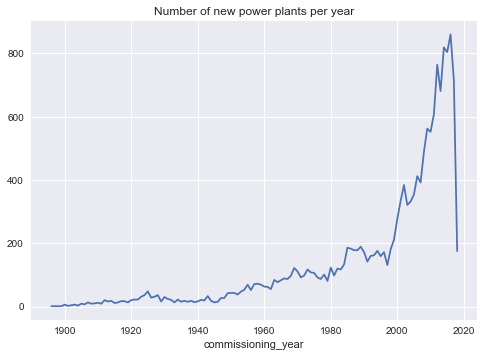

In [16]:
newpp = df_all[['gppd_idnr','country','primary_fuel','commissioning_year']]
newpp = newpp.dropna()
newpp['commissioning_year'] = newpp['commissioning_year'].map(int)
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()
nycountplot = nycount.plot(title = "Number of new power plants per year")
#plt.savefig(r'plots\num_pp_p_year.svg')

**Interpretation:**  Important to note that the energy output data is available only until 2017. We also see a suspicious drop in the amount of new power plants from 2017 to 2018. The latest technical note for the dataset was published in 2019, but almost all sources used are from 2018 (also powerplant data sources). It seems likely that the dataset does not represent the number of new powerplants in 2018 adequately. Therefore, we only include the data from 1896-2017, and explore which fyel types are responsible for the spike(s):

Text(0, 0.5, '#Comissioned Powerplants')

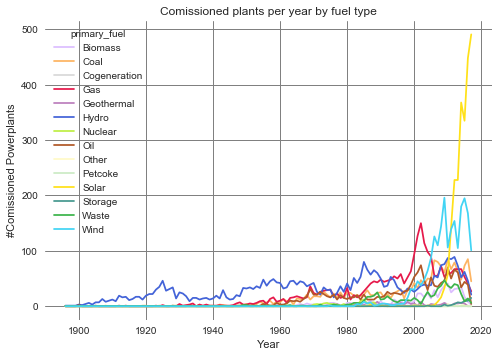

In [17]:
maskyear = newpp["commissioning_year"] != 2018
newpp = newpp[maskyear]
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()
pf_cy = pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"])
fig = (pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"])
        .plot(color = [color_dict.get(x, '#333333') for x in pf_cy.columns]))
plt.title("Comissioned plants per year by fuel type")
plt.xlabel("Year")
plt.grid(color='grey')
ax = plt.gca()
ax.set_facecolor('w')
plt.ylabel("#Comissioned Powerplants")
#plt.savefig(r'plots\comissioned_plants_per_year_by_fuel_type.svg')

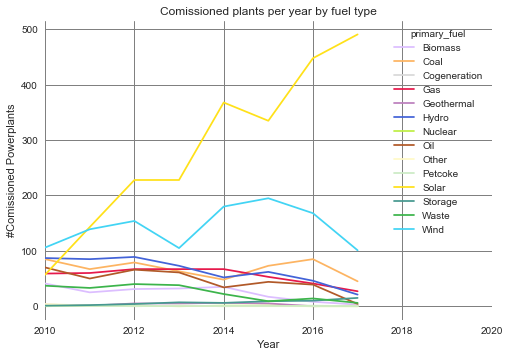

In [18]:
pf_cy.plot(color = [color_dict.get(x, '#333333') for x in pf_cy.columns])
plt.xlim(2010,2020)
plt.title("Comissioned plants per year by fuel type")
plt.xlabel("Year")
plt.ylabel("#Comissioned Powerplants")
plt.grid(color='grey')
ax = plt.gca()
ax.set_facecolor('w')
plt.show()
#plt.savefig(r'plots\comissioned_plants_per_year_by_fuel_type_zoomed.svg')

**Interpretation:** We see that in the recent years, there has been a considerable increase in the number of Solar power plants. We also see that there has been as light increase in the number of new Wind power plants. While not as prominent, there have been new Hydro, Coal, Geothermal, Oil, Biomass power plants. An interesting question is: which countries are responsible for such a  big rise in new Solar power plants?

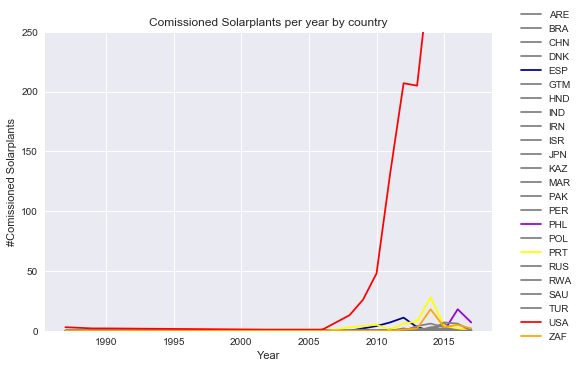

In [19]:
# Exploring which countries are responsible for the spike in solar power plants:
masksolar = newpp["primary_fuel"] == 'Solar'
newsolar = newpp[masksolar]
sol_c_cy = pd.crosstab(newsolar["commissioning_year"], newsolar["country"])
sol_c_cy.plot(color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
plt.ylim(0,250)
plt.title("Comissioned Solarplants per year by country")
plt.xlabel("Year")
plt.ylabel("#Comissioned Solarplants")

plt.legend(bbox_to_anchor=(1.2,1.1))
#plt.savefig(r'plots\comissioned_solar_pp_per_year_by_country.svg')

(0, 50)

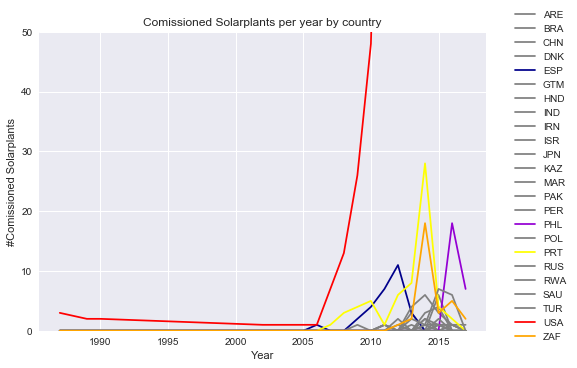

In [20]:
# Zoomed in
sol_c_cy.plot(color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
plt.title("Comissioned Solarplants per year by country")
plt.legend(bbox_to_anchor=(1.2,1.1))
plt.xlabel("Year")
plt.ylabel("#Comissioned Solarplants")
plt.ylim(0,50)

#plt.savefig(r'plots\comissioned_solar_pp_per_year_by_country_zoomed.svg')

**Interpretation:** We see that the most new power plants have been built in USA, but also there has been quite a few new Solar power plants in Spain, Philippines, South Africa, Portugal.

## 1.4. Ratio green energy estimated output over all estimated output (per country)

In [21]:
df_all["is_green"] = df_all["primary_fuel"].apply(lambda x: green_map[x])
maskgreen = df_all['is_green'] == 1
df_all_green = df_all[maskgreen]

# The green ratio for all the entire dataset
df_all_green['estimated_generation_gwh'].sum()/df_all['estimated_generation_gwh'].sum()

0.336362072576162

Text(0.5, 1.0, 'Share of green fuels of total estimated output per country (%)')

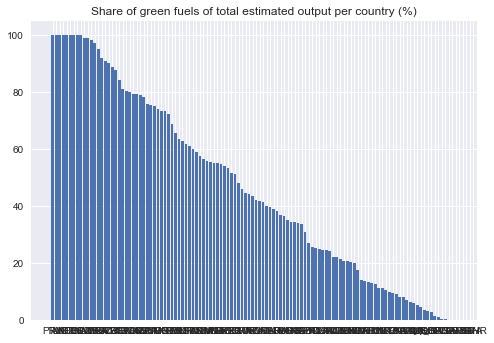

In [90]:
df_all_g = df_all.groupby('country')
df_all_green_g = df_all_green.groupby('country')
totalratiocountry = 100*df_all_green_g['estimated_generation_gwh'].sum()/df_all_g['estimated_generation_gwh'].sum()
totalratiocountry=totalratiocountry.to_frame()
totalratiocountry.reset_index(inplace=True)
totalratiocountry = totalratiocountry.sort_values('estimated_generation_gwh', ascending=False)
totalratiocountry = totalratiocountry.rename(columns={'estimated_generation_gwh':'green_ratio'})
countr = totalratiocountry.groupby('green_ratio')
plt.bar(totalratiocountry['country'],totalratiocountry['green_ratio'])
plt.title("Share of green fuels of total estimated output per country (%)")

In [23]:
# Paraguay, Tajikistan, Albania, Mozambique, Nepal, Ethiopia, Switzerland and Iceland have 100 percent green ratio!
# (Googled the country codes)
print(totalratiocountry[totalratiocountry['green_ratio']==100])

    country  green_ratio
127     PRY        100.0
146     TJK        100.0
2       ALB        100.0
105     MOZ        100.0
116     NPL        100.0
50      ETH        100.0
26      CHE        100.0
74      ISL        100.0


In [24]:
# checking the original dataset
masknpl = df_all['country'] == 'NPL'
npl = df_all[masknpl]
npl

country                                               name  \
14528     NPL        Bhote Koshi Hydroelectric Power Plant Nepal   
14529     NPL           Devighat Hydroelectric Power Plant Nepal   
14530     NPL             Gandak Hydroelectric Power Plant Nepal   
14531     NPL       Kali Gandaki Hydroelectric Power Plant Nepal   
14532     NPL             Khimti Hydroelectric Power Plant Nepal   
14533     NPL        Kulekhani-I Hydroelectric Power Plant Nepal   
14534     NPL       Kulekhani-II Hydroelectric Power Plant Nepal   
14535     NPL         Marsyangdi Hydroelectric Power Plant Nepal   
14536     NPL  Middle Marsyangdi Hydroelectric Power Plant Nepal   
14537     NPL         Modi Khola Hydroelectric Power Plant Nepal   
14538     NPL            Sunkosi Hydroelectric Power Plant Nepal   
14539     NPL           Trishuli Hydroelectric Power Plant Nepal   

          gppd_idnr  capacity_mw  latitude  longitude primary_fuel  \
14528  GEODB0040476        45.00   27.9388    85.9450        Hydro   
14529  GEODB0040484        14.10   27.9212    85.1462        Hydro   
14530  GEODB0044203        15.00   27.4268    83.7918        Hydro   
14531  GEODB0040475       144.00   27.9760    83.5680        Hydro   
14532  GEODB0040485        60.00   27.5500    86.1690        Hydro   
14533  GEODB0040480        60.00   27.5900    85.1550        Hydro   
14534  GEODB0040482        32.00   27.5090    85.0519        Hydro   
14535  GEODB0040477        69.00   27.9262    84.4965        Hydro   
14536  GEODB0040478        70.00   28.1890    84.4195        Hydro   
14537  GEODB0043974        14.80   28.2720    83.7411        Hydro   
14538  GEODB0044207        10.05   27.7806    85.9170        Hydro   
14539  GEODB0040483        24.00   27.9629    85.1707        Hydro   

      other_fuel1 other_fuel2 other_fuel3  ...  source year_of_capacity_data  \
14528         NaN         NaN         NaN  ...   GEODB                2017.0   
14529         NaN         NaN         NaN  ...   GEODB                2017.0   
14530         NaN         NaN         NaN  ...   GEODB                2017.0   
14531         NaN         NaN         NaN  ...   GEODB                2017.0   
14532         NaN         NaN         NaN  ...   GEODB                2017.0   
14533         NaN         NaN         NaN  ...   GEODB                2017.0   
14534         NaN         NaN         NaN  ...   GEODB                2017.0   
14535         NaN         NaN         NaN  ...   GEODB                2017.0   
14536         NaN         NaN         NaN  ...   GEODB                2017.0   
14537         NaN         NaN         NaN  ...   GEODB                2017.0   
14538         NaN         NaN         NaN  ...   GEODB                2017.0   
14539         NaN         NaN         NaN  ...   GEODB                2017.0   

      generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
14528                 NaN                  NaN                  NaN   
14529                 NaN                  NaN                  NaN   
14530                 NaN                  NaN                  NaN   
14531                 NaN                  NaN                  NaN   
14532                 NaN                  NaN                  NaN   
14533                 NaN                  NaN                  NaN   
14534                 NaN                  NaN                  NaN   
14535                 NaN                  NaN                  NaN   
14536                 NaN                  NaN                  NaN   
14537                 NaN                  NaN                  NaN   
14538                 NaN                  NaN                  NaN   
14539                 NaN                  NaN                  NaN   

       generation_gwh_2016  generation_gwh_2017  estimated_generation_gwh  \
14528                  NaN                  NaN                305.591899   
14529                  NaN                  NaN                 95.752128   
14530         

In [25]:
#53 countries with green ratio of >= 50
totalratiocountry[totalratiocountry['green_ratio']>=50].nunique()

country        53
green_ratio    46
dtype: int64

**Interpretation:** We see that while there are countries with 100% green ratio and 53 countries with green ration of >= 50%, the total green ratio for all power plants in the data set is only apprx. 33.6%.

## 1.5. Ratio green energy capacity over all capacity (per country)

Text(0.5, 1.0, 'Share of green fuels of total output capacity per country (%)')

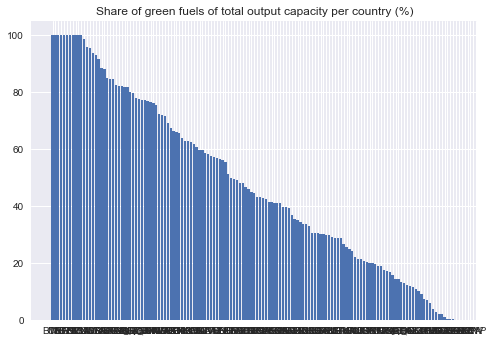

In [91]:
trcapacity = df_all_green_g['capacity_mw'].sum()*100/df_all_g['capacity_mw'].sum()
trcapacity=trcapacity.to_frame()
trcapacity.reset_index(inplace=True)
trcapacity = trcapacity.sort_values('capacity_mw', ascending=False)
trcapacity = trcapacity.rename(columns={'capacity_mw':'green_ratio_capacity'})
plt.bar(trcapacity['country'],trcapacity['green_ratio_capacity'])
plt.title("Share of green fuels of total output capacity per country (%)")

In [27]:
# Bhutan, Mali, Zwitzerland, Mozambique, Ethiopia, Paraguay, Eswatini, Iceland, Nepal, Burundi, Lesotho have 
# green capacity ratio of 100! # (Googled the country codes)
print(trcapacity[trcapacity['green_ratio_capacity']==100])

    country  green_ratio_capacity
22      BTN                 100.0
101     MLI                 100.0
26      CHE                 100.0
105     MOZ                 100.0
50      ETH                 100.0
127     PRY                 100.0
142     SWZ                 100.0
74      ISL                 100.0
116     NPL                 100.0
10      BDI                 100.0
92      LSO                 100.0


**Interpretation:** The results are similar to the results above with calculations on the estimated average. It is surprising, however, that some countries (Bhutan, Mali and Lesotho) with 100% green capacity ratio do not have 100% estimated output ratio. A quick check, however, shows that this is because all energy output values are 'NaN' for Bhutan, Mali and Lesotho.

## 1.6. Estimating annual energy generation with linear regression

**Reminder:** annual energy generation is either the average of actually reported generations between 2013-2017, or the energy generation estimated by the database creators.

**Not accounting for multicolinearity:**

In [57]:
model1 = sm.ols(formula="avg_annual_output ~ capacity_mw+latitude+longitude+primary_fuel+is_green+commissioning_year", data=df_all).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_annual_output   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     6797.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:27:26   Log-Likelihood:            -1.3427e+05
No. Observations:               16238   AIC:                         2.686e+05
Df Residuals:                   16220   BIC:                         2.687e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        568.6723    731.992      0.777      0.437    -866.112    2003.456
primary_fuel[T.Coal]             411.1120    131.890      3.117      0.002     152.593     669.631
primary_fuel[T.Cogeneration]    -130.7435    167.040     -0.783      0.434    -458.160     196.673
primary_fuel[T.Gas]             -188.5846    132.799     -1.420      0.156    -448.886      71.717
primary_fuel[T.Geothermal]       -61.2832     89.076     -0.688      0.491    -235.882     113.316
primary_fuel[T.Hydro]           -240.6978     44.128     -5.454      0.000    -327.194    -154.201
primary_fuel[T.Nuclear]         4896.7963    105.440     46.442      0.000    4690.123    5103.470
primary_fuel[T.Oil]               65.0899    132.829      0.490      0.624    -195.270     325.449
primary_fuel[T.Other]            -26.7000    197.202     -0.135      0.892    -413.237     359.837
primary_fuel[T.Petcoke]           33.2464    263.947      0.126      0.900    -484.119     550.612
primary_fuel[T.Solar]           -141.6454     45.949     -3.083      0.002    -231.711     -51.580
primary_fuel[T.Storage]         -100.0851    131.125     -0.763      0.445    -357.105     156.934
primary_fuel[T.Waste]            -98.4523     54.889     -1.794      0.073    -206.040       9.136
primary_fuel[T.Wave and Tidal]    9.1e-13   3.83e-14     23.729      0.000    8.35e-13    9.85e-13
primary_fuel[T.Wind]            -212.1448     45.417     -4.671      0.000    -301.167    -123.122
capacity_mw                        4.0943      0.015    271.054      0.000       4.065       4.124
latitude                          -0.1783      0.379     -0.471      0.638      -0.920       0.564
longitude                          0.9447      0.125      7.554      0.000       0.700       1.190
is_green                         274.5086    135.962      2.019      0.044       8.008     541.009
commissioning_year                -0.3254      0.426     -0.765      0.444      -1.159       0.509
==============================================================================
Omnibus:                    17045.579   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16577499.118
Skew:                           4.328   Prob(JB):                         0.00
Kurtosis:                     159.291   Cond. No.                     5.66e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.05e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Accounting for colinearity:**

In [59]:
model12 = sm.ols(formula="avg_annual_output ~ capacity_mw+latitude+longitude+primary_fuel+is_green+commissioning_year+capacity_mw*primary_fuel+capacity_mw*commissioning_year+primary_fuel*commissioning_year+latitude*longitude", data=df_all).fit()
model12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_annual_output   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     3004.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:28:11   Log-Likelihood:            -1.3313e+05
No. Observations:               16238   AIC:                         2.664e+05
Df Residuals:                   16192   BIC:                         2.667e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                           917.6560   8209.927      0.112      0.911   -1.52e+04     1.7e+04
primary_fuel[T.Coal]                               6679.7666   8480.097      0.788      0.431   -9942.160    2.33e+04
primary_fuel[T.Cogeneration]                       5928.3305   1.92e+04      0.309      0.757   -3.17e+04    4.35e+04
primary_fuel[T.Gas]                               -4231.0079   8373.825     -0.505      0.613   -2.06e+04    1.22e+04
primary_fuel[T.Geothermal]                         -937.8885   1.37e+04     -0.069      0.945   -2.77e+04    2.59e+04
primary_fuel[T.Hydro]                               1.03e+04   5335.251      1.930      0.054    -162.328    2.08e+04
primary_fuel[T.Nuclear]                            1.888e+05   1.89e+04      9.982      0.000    1.52e+05    2.26e+05
primary_fuel[T.Oil]                                -556.2021   8513.706     -0.065      0.948   -1.72e+04    1.61e+04
primary_fuel[T.Other]                             -1.645e+04   1.49e+04     -1.103      0.270   -4.57e+04    1.28e+04
primary_fuel[T.Petcoke]                             2.34e+04   4.73e+04      0.495      0.621   -6.93e+04    1.16e+05
primary_fuel[T.Solar]                              1.652e+04   1.42e+04      1.163      0.245   -1.13e+04    4.44e+04
primary_fuel[T.Storage]                            1.008e+04   8.87e+04      0.114      0.909   -1.64e+05    1.84e+05
primary_fuel[T.Waste]                              8613.8334   8068.842      1.068      0.286   -7201.989    2.44e+04
primary_fuel[T.Wave and Tidal]                     6.448e-08   3.99e-07      0.162      0.872   -7.17e-07    8.46e-07
primary_fuel[T.Wind]                               2.192e+04   8528.711      2.570      0.010    5197.810    3.86e+04
capacity_mw                                          -0.3880      1.909     -0.203      0.839      -4.130       3.354
capacity_mw:primary_fuel[T.Coal]                     -5.5403      0.764     -7.254      0.000      -7.037      -4.043
capacity_mw:primary_fuel[T.Cogeneration]             -6.9730      5.062     -1.377      0.168     -16.895       2.949
capacity_mw:primary_fuel[T.Gas]                      -6.6920      0.764     -8.758      0.000      -8.190      -5.194
capacity_mw:primary_fuel[T.Geothermal]               -5.5688      1.059     -5.256      0.000      -7.645      -3.492
capacity_mw:primary_fuel[T.Hydro]                    -6.1350      0.764     -8.032      0.000      -7.632      -4.638
capacity_mw:primary_fuel[T.Nuclear]                  -2.3785      0.771     -3.083      0.002      -3.891      -0.866
capacity_mw:primary_fuel[T.Oil]                      -7.1669      0.766     -9.351      0.000      -8.669      -5.665
capacity_mw:pri

**Interpretation:** We see that 'primary_fuel' variable on its own still can have low p-values but the combination of capacity and primary fuel looks much better in terms of p-values. 'Capacity_mw' and 'green' do not have low p-values anymore after accounting for multicolinearity. Latitude and Commissioning year did not have a high p-value from the very beginning, but the combination of longitude and latitude does, as well as the combination of 'capacity_mw' and 'commissioning_year'. Therefore, let's only keep 'longitude:latitude', 'primary_fuel:capacity' and 'capacity:commissioning_year' 

In [60]:
model123 = sm.ols(formula="avg_annual_output ~ latitude*longitude+capacity_mw*primary_fuel+capacity_mw*commissioning_year", data=df_all).fit()
model123.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_annual_output   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     4193.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:28:20   Log-Likelihood:            -1.3319e+05
No. Observations:               16238   AIC:                         2.665e+05
Df Residuals:                   16205   BIC:                         2.667e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   2135.3304    848.061      2.518      0.012     473.037    3797.624
primary_fuel[T.Coal]                        -101.7226     56.716     -1.794      0.073    -212.892       9.447
primary_fuel[T.Cogeneration]                 125.9374    216.312      0.582      0.560    -298.058     549.933
primary_fuel[T.Gas]                           -6.5028     51.351     -0.127      0.899    -107.157      94.151
primary_fuel[T.Geothermal]                   137.4925     95.676      1.437      0.151     -50.044     325.029
primary_fuel[T.Hydro]                        -22.6581     50.053     -0.453      0.651    -120.768      75.452
primary_fuel[T.Nuclear]                      -95.9477    195.660     -0.490      0.624    -479.462     287.567
primary_fuel[T.Oil]                          100.2061     51.630      1.941      0.052      -0.993     201.406
primary_fuel[T.Other]                        331.0723    194.785      1.700      0.089     -50.727     712.872
primary_fuel[T.Petcoke]                       54.0002    283.322      0.191      0.849    -501.342     609.342
primary_fuel[T.Solar]                        132.6592     51.718      2.565      0.010      31.287     234.031
primary_fuel[T.Storage]                      181.8035    157.410      1.155      0.248    -126.737     490.344
primary_fuel[T.Waste]                        140.1872     64.045      2.189      0.029      14.652     265.722
primary_fuel[T.Wave and Tidal]             -1.505e-09   8.72e-09     -0.172      0.863   -1.86e-08    1.56e-08
primary_fuel[T.Wind]                          75.8281     52.657      1.440      0.150     -27.386     179.042
latitude                                       0.2949      0.412      0.716      0.474      -0.512       1.102
longitude                                      0.8199      0.235      3.493      0.000       0.360       1.280
latitude:longitude                             0.0131      0.006      2.120      0.034       0.001       0.025
capacity_mw                                    1.5968      1.752      0.911      0.362      -1.838       5.031
capacity_mw:primary_fuel[T.Coal]              -5.3567      0.759     -7.060      0.000      -6.844      -3.869
capacity_mw:primary_fuel[T.Cogeneration]      -6.8276      5.065     -1.348      0.178     -16.755       3.100
capacity_mw:primary_fuel[T.Gas]               -6.4999      0.759     -8.562      0.000      -7.988      -5.012
capacity_mw:primary_fuel[T.Geothermal]        -5.4742      1.053     -5.196      0.000      -7.539      -3.409
capacity_mw:primary_fuel[T.Hydro]             -5.9496      0.759     -7.841      0.000      -7.437      -4.462
capacity_mw:primary_fuel[T.Nuclear]           -2.4047      0.766     -3.138      0.002

# 2. Analysis on data where Time Series (2013-2017) is complete
## 2.1. Comparison by Year: Boxplot

In [28]:
annual_output(df_ts_complete)
dfc=df_ts_complete[["generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
dfc.describe()

generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
count          6817.000000          6817.000000          6817.000000   
mean            685.020952           688.554481           698.562305   
std            2261.173936          2294.095823          2304.707671   
min            -947.600000          -989.619000          -864.428000   
25%               2.200000             2.632000             2.511000   
50%              27.118000            26.836320            26.576000   
75%             250.443889           247.330068           251.239000   
max           31431.080000         32320.917000         32525.595000   

       generation_gwh_2016  generation_gwh_2017  
count          6817.000000          6817.000000  
mean            676.278993           726.536342  
std            2279.047703          2341.640875  
min            -768.620000          -934.944000  
25%               2.490000             4.348000  
50%              25.858000            36.726000  
75%             246.354000           283.000000  
max           32377.477000         35116.000000

In [29]:
dfc.corr()

generation_gwh_2013  generation_gwh_2014  \
generation_gwh_2013             1.000000             0.962601   
generation_gwh_2014             0.962601             1.000000   
generation_gwh_2015             0.940071             0.972677   
generation_gwh_2016             0.913186             0.945576   
generation_gwh_2017             0.920023             0.932240   

                     generation_gwh_2015  generation_gwh_2016  \
generation_gwh_2013             0.940071             0.913186   
generation_gwh_2014             0.972677             0.945576   
generation_gwh_2015             1.000000             0.967203   
generation_gwh_2016             0.967203             1.000000   
generation_gwh_2017             0.950799             0.954612   

                     generation_gwh_2017  
generation_gwh_2013             0.920023  
generation_gwh_2014             0.932240  
generation_gwh_2015             0.950799  
generation_gwh_2016             0.954612  
generation_gwh_2017             1.000000

**Boxplots with outliers:**

Text(0.5, 1.0, 'Distribution of energy output by year')

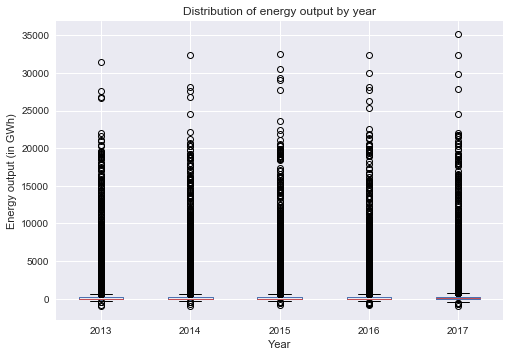

In [92]:
dfc.boxplot(showfliers=True) 
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")
plt.title("Distribution of energy output by year")

**Boxplots without outliers:**

Text(0, 0.5, 'Energy output (in GWh)')

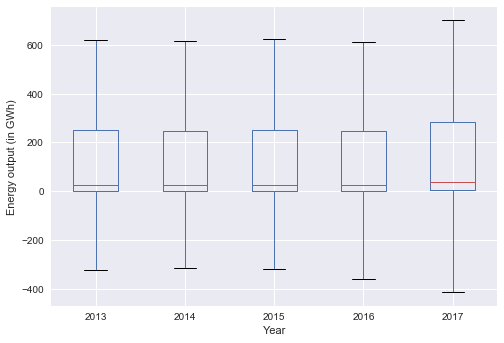

In [31]:
dfc.boxplot(showfliers=False) 
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")
plt.title("Distribution of energy output by year without outliers")

**Interpretation:** It seems like there is a slight rise in energy production from 2013 to 2017, judging by the mean and max values above. However, the boxplots do not seem to show a significant difference. So, is there an increase in energy output throughout the years? Let's use ANOVA hypothesis testing as outlined in the hypothesis testing lecture from the Data Analysis course. So the null hypothesis is that the mean is similar for all 5 years (2013,2014,2015,2016 and 2017). And the alternative hypothesis is that there is a difference between the means.

## 2.2. Hypothesis Testing

### All

In [32]:
f_oneway(dfc["generation_gwh_2013"],dfc["generation_gwh_2014"],dfc["generation_gwh_2015"],dfc["generation_gwh_2016"],dfc["generation_gwh_2017"])

F_onewayResult(statistic=0.4844310257151508, pvalue=0.7472116879156799)

**Interpretation:** We see that the p-value is quite high, and definitely bigger than the standard 0.05 value. Therefore, we can conclude that the difference in the means between years is most likely due to chance, and that the difference in the means between years is not statistically significant. Let's see if there is a difference year-by-year using the t-test, as outlined in the hypothesis testing lecture from the Data Analysis course:

In [33]:
t34, pval34 = ttest_ind(dfc["generation_gwh_2013"],dfc["generation_gwh_2014"])
print(t34, pval34)

-0.0905721872385206 0.927833863137513


In [34]:
t45, pval45= ttest_ind(dfc["generation_gwh_2014"],dfc["generation_gwh_2015"])
print(t45, pval45)

-0.2541003700460045 0.7994218499245451


In [35]:
t56, pval56 = ttest_ind(dfc["generation_gwh_2015"],dfc["generation_gwh_2016"])
print(t56, pval56)

0.5676271409315731 0.5702975216773792


In [36]:
t67, pval67 = ttest_ind(dfc["generation_gwh_2016"],dfc["generation_gwh_2017"])
print(t67, pval67)

-1.269885828512222 0.2041469777748902


**Interpretation:** There does not seem to be a significant difference as all p-values are higher than 0.05. The p-value steadily decrease with years, though. Now, it would be interesting to look specifically at Solar and Wind energy outputs, as from the plots above we see that there have been quite a lot of new power plants of these fuel types.

### Solar and Wind only

In [37]:
dfc1=df_ts_complete[["primary_fuel","generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
solar= dfc1[dfc1["primary_fuel"].str.contains('Solar')==True] 
solar.describe()

generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
count           614.000000           614.000000           614.000000   
mean             14.176807            23.480800            25.716058   
std              45.808663            86.351426            97.053440   
min              -0.116000            -0.064000             0.000000   
25%               1.648575             2.133587             2.145498   
50%               2.812500             3.854000             4.003000   
75%               8.333750            10.263250            10.188000   
max             675.525000          1105.857000          1301.337000   

       generation_gwh_2016  generation_gwh_2017  
count           614.000000           614.000000  
mean             25.673569            25.304770  
std              95.958802            95.268087  
min               0.000000            -0.394000  
25%               2.269750             2.084500  
50%               4.190500             3.851500  
75%              10.652750            10.362750  
max            1265.760000          1237.532000

In [38]:
f_oneway(solar["generation_gwh_2013"],solar["generation_gwh_2014"],solar["generation_gwh_2015"],solar["generation_gwh_2016"],solar["generation_gwh_2017"])

F_onewayResult(statistic=2.015291963206134, pvalue=0.08964832944489949)

**Interpretation:** The p-value is pretty small, but still a bit bigger than 0.05. Let's look year-by-year:

In [39]:
t34, pval34 = ttest_ind(solar["generation_gwh_2013"],solar["generation_gwh_2014"])
print(t34, pval34)

-2.3585122543025445 0.018504599184205738


In [40]:
t45, pval45= ttest_ind(solar["generation_gwh_2014"],solar["generation_gwh_2015"])
print(t45, pval45)

-0.4263614978351133 0.669919300374153


In [41]:
t56, pval56 = ttest_ind(solar["generation_gwh_2015"],solar["generation_gwh_2016"])
print(t56, pval56)

0.00771399987537734 0.9938464346216395


In [42]:
t67, pval67 = ttest_ind(solar["generation_gwh_2016"],solar["generation_gwh_2017"])
print(t67, pval67)

0.06758297931746103 0.9461286246539437


**Interpretation:** So only for 2013-2014, the difference in mean could have been statistically significant. This is interesting, considering how many new power plants there have been built in 2010-2017, and that the country which seems to be responsible for the spike in new solar power plants seem to be the US (which is included in the complete time series dataset). Let's now look at wind:

In [43]:
wind = dfc1[dfc1["primary_fuel"].str.contains('Wind')==True] 
wind["primary_fuel"].unique()
wind.describe()

generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
count           815.000000           815.000000           815.000000   
mean            212.506884           225.655921           209.646224   
std             242.456165           259.101596           236.785529   
min               0.000000             0.000000             0.000000   
25%              24.775500            24.560000            23.010000   
50%             136.132000           147.864000           140.907000   
75%             332.800500           353.121000           326.288000   
max            1983.817000          2309.100000          1965.895000   

       generation_gwh_2016  generation_gwh_2017  
count           815.000000           815.000000  
mean            216.898017           211.177503  
std             245.592186           240.213925  
min               0.000000             0.000000  
25%              22.551000            21.528000  
50%             145.288000           144.709000  
75%             332.927500           319.801500  
max            2159.583000          1972.964000

In [44]:
f_oneway(wind["generation_gwh_2013"],wind["generation_gwh_2014"],wind["generation_gwh_2015"],wind["generation_gwh_2016"],wind["generation_gwh_2017"])

F_onewayResult(statistic=0.5653461294252046, pvalue=0.6878214078525545)

In [45]:
t34, pval34 = ttest_ind(wind["generation_gwh_2013"],wind["generation_gwh_2014"])
print(t34, pval34)

-1.0578589477795648 0.2902766909778453


In [46]:
t45, pval45= ttest_ind(wind["generation_gwh_2014"],wind["generation_gwh_2015"])
print(t45, pval45)

1.3021312251374135 0.19305572396027426


In [47]:
t56, pval56 = ttest_ind(wind["generation_gwh_2015"],wind["generation_gwh_2016"])
print(t56, pval56)

-0.606847569252496 0.5440366937392533


In [48]:
t67, pval67 = ttest_ind(wind["generation_gwh_2016"],wind["generation_gwh_2017"])
print(t67, pval67)

0.47537824151633173 0.6345811734015576


**Interpretation:** Not statistically significant.

## 2.3. Stacked barplot energy output per fuel type (by country)

In [49]:
dfc2=df_ts_complete[["country","primary_fuel","generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
aus = dfc2[dfc2["country"].str.contains('AUS')==True] 
ind = dfc2[dfc2["country"].str.contains('IND')==True] 
usa = dfc2[dfc2["country"].str.contains('USA')==True] 
ausfuel = aus.groupby("primary_fuel")

# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
ausfuel = ausfuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
ausfuel = ausfuel.sort_values(by='generation_2013_sum', ascending = False)
ausfuel = ausfuel.transpose() 
ausfuel = ausfuel.reset_index()

indfuel = ind.groupby("primary_fuel")
indfuel = indfuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
indfuel = indfuel.sort_values(by='generation_2013_sum', ascending = False)
indfuel = indfuel.transpose()
indfuel = indfuel.reset_index()

usafuel = usa.groupby("primary_fuel")
usafuel = usafuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
usafuel = usafuel.sort_values(by='generation_2013_sum', ascending = False)
usafuel = usafuel.transpose() 
usafuel = usafuel.reset_index()

Text(0.5, 1.0, 'Australia')

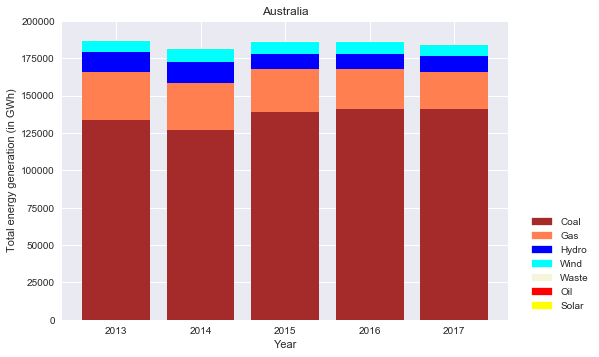

In [102]:
p1 = plt.bar(ausfuel["index"], ausfuel["Coal"], color='brown')
p2 = plt.bar(ausfuel["index"], ausfuel["Gas"] ,bottom = ausfuel["Coal"], color='coral')
p3 = plt.bar(ausfuel["index"], ausfuel["Hydro"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"])], color='blue')
p4 = plt.bar(ausfuel["index"], ausfuel["Wind"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"])],
             color='cyan')
p5 = plt.bar(ausfuel["index"], ausfuel["Waste"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"])],
             color='beige')
p6 = plt.bar(ausfuel["index"], ausfuel["Oil"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"],ausfuel["Waste"])],
             color='red')
p7 = plt.bar(ausfuel["index"], ausfuel["Solar"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"],ausfuel["Waste"],ausfuel["Oil"])],
             color='yellow')
plt.ylim(0,200000)
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Gas':"coral", 'Hydro':"blue","Wind":"cyan", "Waste":"beige","Oil":"red","Solar":"yellow"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("Australia")

Text(0.5, 1.0, 'India')

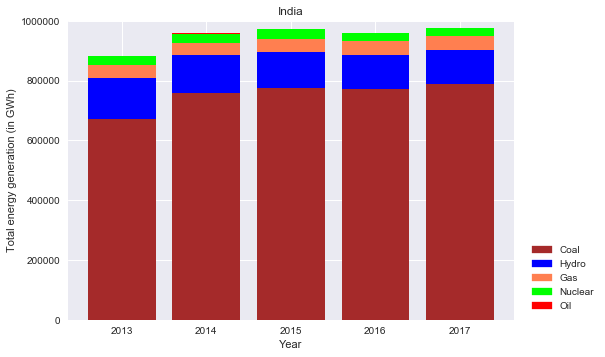

In [101]:
p1 = plt.bar(indfuel["index"], indfuel["Coal"], color='brown')
p2 = plt.bar(indfuel["index"], indfuel["Hydro"] ,bottom = indfuel["Coal"], color='blue')
p3 = plt.bar(indfuel["index"], indfuel["Gas"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"])], color='coral')
p4 = plt.bar(indfuel["index"], indfuel["Nuclear"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"],indfuel["Gas"])],
             color='lime')
p5 = plt.bar(indfuel["index"], indfuel["Oil"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"],indfuel["Gas"], indfuel["Nuclear"])],
             color='red')
plt.ylim(0,1000000)
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

colors = {'Coal':"brown", 'Hydro':"blue", 'Gas':"coral", "Nuclear":"lime","Oil":"red"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("India")

Text(0.5, 1.0, 'USA')

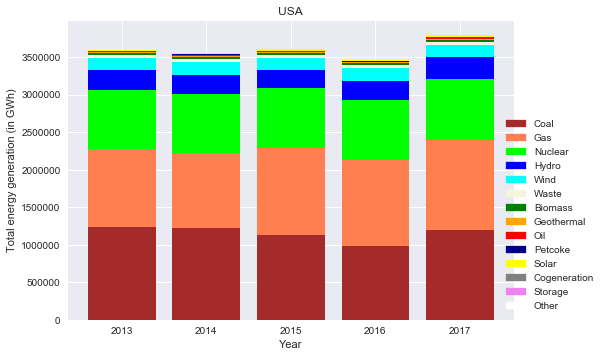

In [52]:
p1 = plt.bar(usafuel["index"], usafuel["Coal"], color='brown')
p2 = plt.bar(usafuel["index"], usafuel["Gas"] ,bottom = usafuel["Coal"], color='coral')
p3 = plt.bar(usafuel["index"], usafuel["Nuclear"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"])], color='lime')
p4 = plt.bar(usafuel["index"], usafuel["Hydro"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"])],
             color='blue')
p5 = plt.bar(usafuel["index"], usafuel["Wind"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"])],
             color='cyan')
p6 = plt.bar(usafuel["index"], usafuel["Waste"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"])],
             color='beige')
p7 = plt.bar(usafuel["index"], usafuel["Biomass"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"])],
             color='green')
p8 = plt.bar(usafuel["index"], usafuel["Geothermal"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"])],
             color='orange')
p9 = plt.bar(usafuel["index"], usafuel["Oil"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"])],
             color='red')
p10 = plt.bar(usafuel["index"], usafuel["Petcoke"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"])],
             color='darkblue')
p11 = plt.bar(usafuel["index"], usafuel["Solar"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"])],
             color='yellow')
p12 = plt.bar(usafuel["index"], usafuel["Cogeneration"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"])],
             color='grey')
p13 = plt.bar(usafuel["index"], usafuel["Storage"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"],usafuel["Cogeneration"])],
             color='violet')
p14 = plt.bar(usafuel["index"], usafuel["Other"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"],usafuel["Cogeneration"],usafuel["Storage"])],
             color='white')
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

colors = {'Coal':"brown", 'Gas':"coral", "Nuclear":"lime", "Hydro":"blue","Wind":"cyan","Waste":"beige","Biomass":"green","Geothermal":"orange","Oil":"red","Petcoke":"darkblue","Solar":"yellow","Cogeneration":"grey","Storage":"violet","Other":"white"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("USA")

**Interpretation:** We see that Coal and Gas are still major energy providers for Australia, India and USA. Nuclear, Hydro and Wind energies are also relatively important.

## 2.4. Line plot: ratio of energy output green fuel types over total energy output per year

Text(0.5, 1.0, 'Australia')

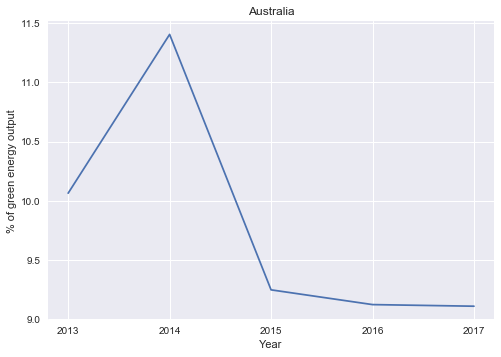

In [53]:
ausfuel['green'] = ausfuel["Hydro"]+ausfuel["Wind"]+ausfuel["Waste"]+ausfuel["Solar"]
ausfuel['all'] = ausfuel[list(ausfuel.columns)].sum(axis=1)
ausfuel['greenpercent'] = ausfuel['green']*100/ausfuel['all']
ausfuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("Australia")

Text(0.5, 1.0, 'India')

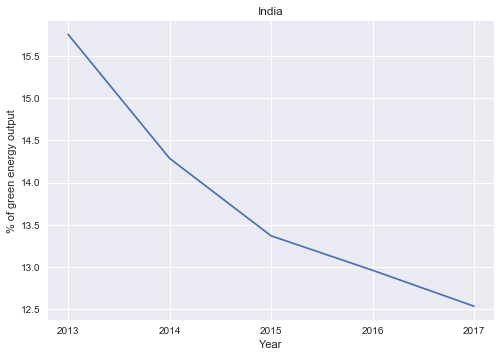

In [54]:
indfuel['green'] = indfuel["Hydro"]+indfuel["Nuclear"]
indfuel['all'] = indfuel[list(indfuel.columns)].sum(axis=1)
indfuel['greenpercent'] = indfuel['green']*100/indfuel['all']
indfuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("India")

Text(0.5, 1.0, 'USA')

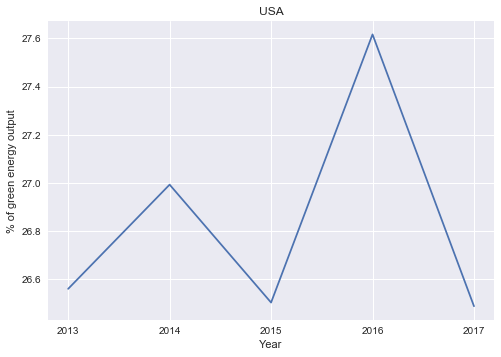

In [55]:
usafuel['green'] = usafuel["Nuclear"]+usafuel["Hydro"]+usafuel["Wind"]+usafuel["Waste"]+usafuel["Biomass"]+usafuel["Geothermal"]+usafuel["Solar"]
usafuel['all'] = usafuel[list(usafuel.columns)].sum(axis=1)
usafuel['greenpercent'] = usafuel['green']*100/usafuel['all']
usafuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("USA")

**Interpretation:** We see that unfortunately, neither Australia nor India or USA has a clear constant upward trend in the percentage of green energy output, and that in 2017 that percentage actually decreased for all three countries when compared to 2013.

# 3. Analysis on US Data
## 3.1. Location of powerplants in the US

In [61]:
_, df_ts_complete, *_ = read_clean_and_split()

In [62]:
df_US = df_ts_complete[df_ts_complete['country'] == 'USA']

In [104]:
fig = px.scatter_geo(df_US,
                        lat=df_US["latitude"],
                        lon=df_US["longitude"],
                        hover_name=df_US["name"],
                        color = df_US["primary_fuel"],
                        color_discrete_map = color_dict,                       
                        title = 'Location of Powerplants U.S.'
                        )
fig.update_layout(        
        geo_scope='usa',
    )
fig.show()
#fig.write_html("plots/map_us_pp_location.html")

## 3.2. Differences between US states

In [63]:
# Adds a column with us_state to dataframe df
# The used library for reverse geocoding works with K-D trees.
# Might produce inaccurate results for border regions
def coordinate_to_state(df):
    
    coordinates = [*zip(df['latitude'], df['longitude'])]
    #Uncomment below to include (lat, long) tuple as new column in df
    #df.insert(4, 'coordinates', coordinates)

    geo_infos = rg.search(tuple(coordinates))

    locations = list()

    for item in geo_infos:
        locations.append(item['admin1'])

    df.insert(1, 'us_state', locations)   


In [64]:
# Fixes the obvious mistakes made by coordinate_to_state function (where us_state is not a US state)
# Based on looking up the locations manually
def fix_misclassification(df):
    #British Columbia
    df.at['USA0054249', 'us_state'] = 'Idaho'
    df.loc[df['us_state']=='British Columbia', 'us_state'] = 'Washington'
    
    #Quebec
    df.at['USA0056829', 'us_state'] = 'Maine'
    df.loc[df['us_state']=='Quebec', 'us_state'] = 'New York'
    
    #Baja California
    df.at['USA0000120', 'us_state'] = 'Arizona'
    df.loc[df['us_state']=='Baja California', 'us_state'] = 'California'
    
    #Ontario 
    df.at['USA0006369', 'us_state'] = 'Michigan'
    df.at['USA0010487', 'us_state'] = 'Minnesota'
    df.at['USA0002694', 'us_state'] = 'New York'
    
    #Chukotskiy Avtonomnyy Okrug
    df.loc[df['us_state']=='Chukotskiy Avtonomnyy Okrug', 'us_state'] = 'Alaska'
    
    #Tamaulipas
    df.loc[df['us_state']=='Tamaulipas', 'us_state'] = 'Texas'
    
    #Yukon
    df.loc[df['us_state']=='Yukon', 'us_state'] = 'Alaska'   

In [65]:
coordinate_to_state(df_US)
fix_misclassification(df_US)

Loading formatted geocoded file...


In [66]:
# Check results
df_US['us_state'].value_counts()

California          912
New York            327
Texas               320
Minnesota           255
Iowa                213
North Carolina      207
Michigan            199
Pennsylvania        185
Illinois            183
New Jersey          182
Wisconsin           169
Massachusetts       160
Washington          132
Idaho               127
Ohio                126
Florida             125
Alaska              125
Oregon              124
Colorado            124
Kansas              117
Virginia            116
Georgia             113
Indiana             100
Missouri             95
Arizona              93
South Carolina       93
Nebraska             90
Maine                89
Oklahoma             77
Louisiana            75
Connecticut          75
Alabama              72
Utah                 67
New Mexico           65
Maryland             63
Nevada               63
New Hampshire        60
Wyoming              58
Vermont              57
Tennessee            53
Arkansas             52
Montana         

In [69]:
df_US['is_green'] = df_US['primary_fuel'].apply(lambda x: green_map[x])

In [70]:
#Returns a pivot table containing the ratio of green fuel generation / total fuel generation per year per state
def green_ratio_per_state(df_US):
    df_US = df_US[df_US['primary_fuel']!='Other']
    df_US['green_gwh_2013'] = df_US['generation_gwh_2013']*df_US['is_green']
    df_US['green_gwh_2014'] = df_US['generation_gwh_2014']*df_US['is_green']
    df_US['green_gwh_2015'] = df_US['generation_gwh_2015']*df_US['is_green']
    df_US['green_gwh_2016'] = df_US['generation_gwh_2016']*df_US['is_green']
    df_US['green_gwh_2017'] = df_US['generation_gwh_2017']*df_US['is_green']
    
    values = ['generation_gwh_2013', 'green_gwh_2013', 'generation_gwh_2014', 'green_gwh_2014', 'generation_gwh_2015', 'green_gwh_2015', 'generation_gwh_2016', 'green_gwh_2016','generation_gwh_2017', 'green_gwh_2017']

    pt = pd.pivot_table(df_US,index=["us_state"], values=values, aggfunc=np.sum)
    
    pt['2013'] = pt['green_gwh_2013']/pt['generation_gwh_2013']
    pt['2014'] = pt['green_gwh_2014']/pt['generation_gwh_2014']
    pt['2015'] = pt['green_gwh_2015']/pt['generation_gwh_2015']
    pt['2016'] = pt['green_gwh_2016']/pt['generation_gwh_2016']
    pt['2017'] = pt['green_gwh_2017']/pt['generation_gwh_2017']
    
    pt = pt.drop('Washington, D.C.') #has only one powerplant

    return pt, pt[['2013','2014', '2015','2016','2017']]

In [71]:
_, pt = green_ratio_per_state(df_US)
pt

2013      2014      2015      2016      2017
us_state                                                        
Alabama         0.449954  0.453324  0.437674  0.454043  0.399506
Alaska          0.254428  0.312361  0.334680  0.359345  0.296758
Arizona         0.349336  0.405376  0.406509  0.418049  0.408148
Arkansas        0.257145  0.286701  0.339753  0.300151  0.271968
California      0.401862  0.385123  0.378653  0.481645  0.525750
Colorado        0.102204  0.114266  0.105093  0.119395  0.113537
Connecticut     0.712929  0.695986  0.514323  0.498962  0.527072
Delaware        0.902666  0.922609  0.808972  0.805701  0.840813
Florida         0.237783  0.272312  0.286022  0.280565  0.185365
Georgia         0.391162  0.288953  0.275682  0.209712  0.203409
Hawaii          0.132218  0.178928  0.201190  0.206628  0.141007
Idaho           0.853574  0.901898  0.854134  0.883634  0.832281
Illinois        0.455351  0.520077  0.521526  0.577963  0.481541
Indiana         0.044734  0.044367  0.052309  0.056807  0.052157
Iowa            0.603725  0.610351  0.613959  0.653854  0.628197
Kansas          0.338394  0.393440  0.423927  0.412158  0.471059
Kentucky        0.048079  0.043575  0.047159  0.046779  0.057315
Louisiana       0.223250  0.222867  0.184925  0.204630  0.208600
Maine           0.636248  0.569982  0.597822  0.576495  0.675293
Maryland        0.441730  0.435927  0.437337  0.499053  0.563523
Massachusetts   0.275093  0.344698  0.298087  0.301347  0.265558
Michigan        0.390174  0.417928  0.344179  0.371467  0.359375
Minnesota       0.514938  0.532719  0.526973  0.537121  0.461962
Mississippi     0.239324  0.216332  0.220913  0.133675  0.162057
Missouri        0.206668  0.218169  0.251899  0.237525  0.209902
Montana         0.437929  0.461896  0.416310  0.450550  0.474020
Nebraska        0.160291  0.172709  0.183469  0.199959  0.144152
Nevada          0.237811  0.275542  0.236976  0.240120  0.252873
New Hampshire   0.745139  0.737137  0.688621  0.786670  0.813803
New Jersey      0.179412  0.153133  0.153642  0.138083  0.200937
New Mexico      0.117984  0.120748  0.070202  0.107846  0.086871
New York        0.584820  0.587056  0.596027  0.609596  0.598259
North Carolina  0.455068  0.410809  0.427474  0.442881  0.406191
North Dakota    0.277802  0.322700  0.281603  0.286441  0.229541
Ohio            0.246884  0.239947  0.232070  0.219851  0.223717
Oklahoma        0.212902  0.254263  0.209691  0.223365  0.214056
Oregon          0.625950  0.629119  0.627738  0.631569  0.653120
Pennsylvania    0.415493  0.424073  0.444324  0.521209  0.470782
Rhode Island    0.008488  0.034490  0.033129  0.032842  0.029009
South Carolina  0.696346  0.672060  0.701019  0.801988  0.685430
South Dakota    0.936289  0.950958  0.914940  0.893021  0.929276
Tennessee       0.548101  0.484715  0.477558  0.477627  0.543095
Texas           0.191797  0.200827  0.189908  0.201821  0.190900
Utah            0.034346  0.048422  0.046302  0.055365  0.071426
Vermont         0.961276  0.969085  0.968865  0.969672  0.973545
Virginia        0.529101  0.524812  0.496896  0.550363  0.482137
Washington      0.923726  0.936390  0.865985  0.894226  0.875378
West Virginia   0.039029  0.032938  0.041282  0.048712  0.036933
Wisconsin       0.332035  0.388132  0.290647  0.430685  0.230767
Wyoming         0.113368  0.121432  0.108451  0.130166  0.126844

In [72]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [73]:
# plotting libraries expect state-code as input
states = list(pt.index)
pt['code']=list(map(lambda x: us_state_abbrev[x], states))
pt

2013      2014      2015      2016      2017 code
us_state                                                             
Alabama         0.449954  0.453324  0.437674  0.454043  0.399506   AL
Alaska          0.254428  0.312361  0.334680  0.359345  0.296758   AK
Arizona         0.349336  0.405376  0.406509  0.418049  0.408148   AZ
Arkansas        0.257145  0.286701  0.339753  0.300151  0.271968   AR
California      0.401862  0.385123  0.378653  0.481645  0.525750   CA
Colorado        0.102204  0.114266  0.105093  0.119395  0.113537   CO
Connecticut     0.712929  0.695986  0.514323  0.498962  0.527072   CT
Delaware        0.902666  0.922609  0.808972  0.805701  0.840813   DE
Florida         0.237783  0.272312  0.286022  0.280565  0.185365   FL
Georgia         0.391162  0.288953  0.275682  0.209712  0.203409   GA
Hawaii          0.132218  0.178928  0.201190  0.206628  0.141007   HI
Idaho           0.853574  0.901898  0.854134  0.883634  0.832281   ID
Illinois        0.455351  0.520077  0.521526  0.577963  0.481541   IL
Indiana         0.044734  0.044367  0.052309  0.056807  0.052157   IN
Iowa            0.603725  0.610351  0.613959  0.653854  0.628197   IA
Kansas          0.338394  0.393440  0.423927  0.412158  0.471059   KS
Kentucky        0.048079  0.043575  0.047159  0.046779  0.057315   KY
Louisiana       0.223250  0.222867  0.184925  0.204630  0.208600   LA
Maine           0.636248  0.569982  0.597822  0.576495  0.675293   ME
Maryland        0.441730  0.435927  0.437337  0.499053  0.563523   MD
Massachusetts   0.275093  0.344698  0.298087  0.301347  0.265558   MA
Michigan        0.390174  0.417928  0.344179  0.371467  0.359375   MI
Minnesota       0.514938  0.532719  0.526973  0.537121  0.461962   MN
Mississippi     0.239324  0.216332  0.220913  0.133675  0.162057   MS
Missouri        0.206668  0.218169  0.251899  0.237525  0.209902   MO
Montana         0.437929  0.461896  0.416310  0.450550  0.474020   MT
Nebraska        0.160291  0.172709  0.183469  0.199959  0.144152   NE
Nevada          0.237811  0.275542  0.236976  0.240120  0.252873   NV
New Hampshire   0.745139  0.737137  0.688621  0.786670  0.813803   NH
New Jersey      0.179412  0.153133  0.153642  0.138083  0.200937   NJ
New Mexico      0.117984  0.120748  0.070202  0.107846  0.086871   NM
New York        0.584820  0.587056  0.596027  0.609596  0.598259   NY
North Carolina  0.455068  0.410809  0.427474  0.442881  0.406191   NC
North Dakota    0.277802  0.322700  0.281603  0.286441  0.229541   ND
Ohio            0.246884  0.239947  0.232070  0.219851  0.223717   OH
Oklahoma        0.212902  0.254263  0.209691  0.223365  0.214056   OK
Oregon          0.625950  0.629119  0.627738  0.631569  0.653120   OR
Pennsylvania    0.415493  0.424073  0.444324  0.521209  0.470782   PA
Rhode Island    0.008488  0.034490  0.033129  0.032842  0.029009   RI
South Carolina  0.696346  0.672060  0.701019  0.801988  0.685430   SC
South Dakota    0.936289  0.950958  0.914940  0.893021  0.929276   SD
Tennessee       0.548101  0.484715  0.477558  0.477627  0.543095   TN
Texas           0.191797  0.200827  0.189908  0.201821  0.190900   TX
Utah            0.034346  0.048422  0.046302  0.055365  0.071426   UT
Vermont         0.961276  0.969085  0.968865  0.969672  0.973545   VT
Virginia        0.529101  0.524812  0.496896  0.550363  0.482137   VA
Washington      0.923726  0.936390  0.865985  0.894226  0.875378   WA
West Virginia   0.039029  0.032938  0.041282  0.048712  0.036933   WV
Wisconsin       0.332035  0.388132  0.290647  0.430685  0.230767   WI
Wyoming         0.113368  0.121432  0.108451  0.130166  0.126844   WY

In [74]:
#px.chloropleth expects data in a certain shape, so we need to reshape

pt['us_state'] = pt.index

pt2 = pt.melt(id_vars=['us_state', 'code'], 
        var_name='year', 
        value_name='Green fuels (%)')

pt2

us_state code  year  Green fuels (%)
0          Alabama   AL  2013         0.449954
1           Alaska   AK  2013         0.254428
2          Arizona   AZ  2013         0.349336
3         Arkansas   AR  2013         0.257145
4       California   CA  2013         0.401862
..             ...  ...   ...              ...
245       Virginia   VA  2017         0.482137
246     Washington   WA  2017         0.875378
247  West Virginia   WV  2017         0.036933
248      Wisconsin   WI  2017         0.230767
249        Wyoming   WY  2017         0.126844

[250 rows x 4 columns]

In [75]:
fig = px.choropleth(pt2, 
              locations='code', 
              locationmode = 'USA-states', 
              scope = 'usa', 
              color="Green fuels (%)", 
              hover_name="Green fuels (%)", 
              hover_data=['us_state'],
              animation_frame="year",              
              color_continuous_scale=["white", "green"])

fig.update_layout(
    title_text = 'U.S. Green over non-Green fuels by State',
)
fig.show()
#fig.write_html("plots/map_us_green_ratio_states.html")

## 3.3. Statistical Analyses

### Correlation Analysis

In [76]:
df_US.drop(['year_of_capacity_data', 'estimated_generation_gwh'], axis=1, inplace=True)
df_US

country    us_state                                  name  \
gppd_idnr                                                              
USA0059371     USA  New Jersey                12 Applegate Solar LLC   
USA0057310     USA  California                       1420 Coil Av #C   
USA0057458     USA  New Jersey                    145 Talmadge Solar   
USA0007770     USA    Illinois                     1515 S Caron Road   
USA0058187     USA  New Jersey                     180 Raritan Solar   
...            ...         ...                                   ...   
USA0055392     USA    Illinois                    Zion Energy Center   
USA0056871     USA    Illinois  Zion Landfill Gas to Energy Facility   
USA0001368     USA     Indiana                                  Zorn   
USA0057648     USA    New York              Zotos International WPGF   
USA0059281     USA        Utah                   eBay - South Jordan   

            capacity_mw  latitude  longitude primary_fuel other_fuel1  \
gppd_idnr                                                               
USA0059371          1.9   40.2003   -74.5761        Solar         NaN   
USA0057310          1.3   33.7943  -118.2414        Solar         NaN   
USA0057458          3.8   40.5358   -74.3913        Solar         NaN   
USA0007770          4.2   41.9084   -89.0466          Gas         NaN   
USA0058187          1.9   40.5161   -74.3400        Solar         NaN   
...                 ...       ...        ...          ...         ...   
USA0055392        596.7   42.4776   -87.8950          Gas         Oil   
USA0056871          7.0   42.4803   -87.8861        Waste         NaN   
USA0001368         18.0   38.2803   -85.7023          Gas         NaN   
USA0057648          3.4   42.8869   -76.9683         Wind         NaN   
USA0059281          9.8   40.5606  -112.0478          Gas         NaN   

           other_fuel2 other_fuel3  commissioning_year  \
gppd_idnr                                                
USA0059371         NaN         NaN         2012.000000   
USA0057310         NaN         NaN         2011.000000   
USA0057458         NaN         NaN         2011.000000   
USA0007770         NaN         NaN         2000.000000   
USA0058187         NaN         NaN         2012.000000   
...                ...         ...                 ...   
USA0055392         NaN         NaN         2002.333333   
USA0056871         NaN         NaN         2003.000000   
USA0001368         NaN         NaN         1969.000000   
USA0057648         NaN         NaN         2012.000000   
USA0059281         NaN         NaN         2013.775510   

                                        owner  \
gppd_idnr                                       
USA0059371                   SunRay Power LLC   
USA0057310                    Konoike Pacific   
USA0057458            Avidan Energy Solutions   
USA0007770       Rochelle Municipal Utilities   
USA0058187  180 Raritan Energy Solutions  LLC   
...                                       ...   
USA0055392                    Zion Energy LLC   
USA0056871            Energy Developments Inc   
USA0001368       Louisville Gas & Electric Co   
USA0057648                Zotos International   
USA0059281                       Bloom Energy   

                                            source  generation_gwh_2013  \
gppd_idnr                                                                 
USA0059371  U.S. Energy Information Administration              2.41461   
USA0057310  U.S. Energy Information Administration              1.52800   
USA0057458  U.S. Energy Information Administration              5.03600   
USA0007770  U.S. Energy Information Administration              0.21500   
USA0058187  U.S. Energy Information Administration              2.74100   
...                                            ...                  ...   
USA0055392  U.S. Energy Information Administration              0.00000   
USA0056871  U.S. Energy Information Administration      

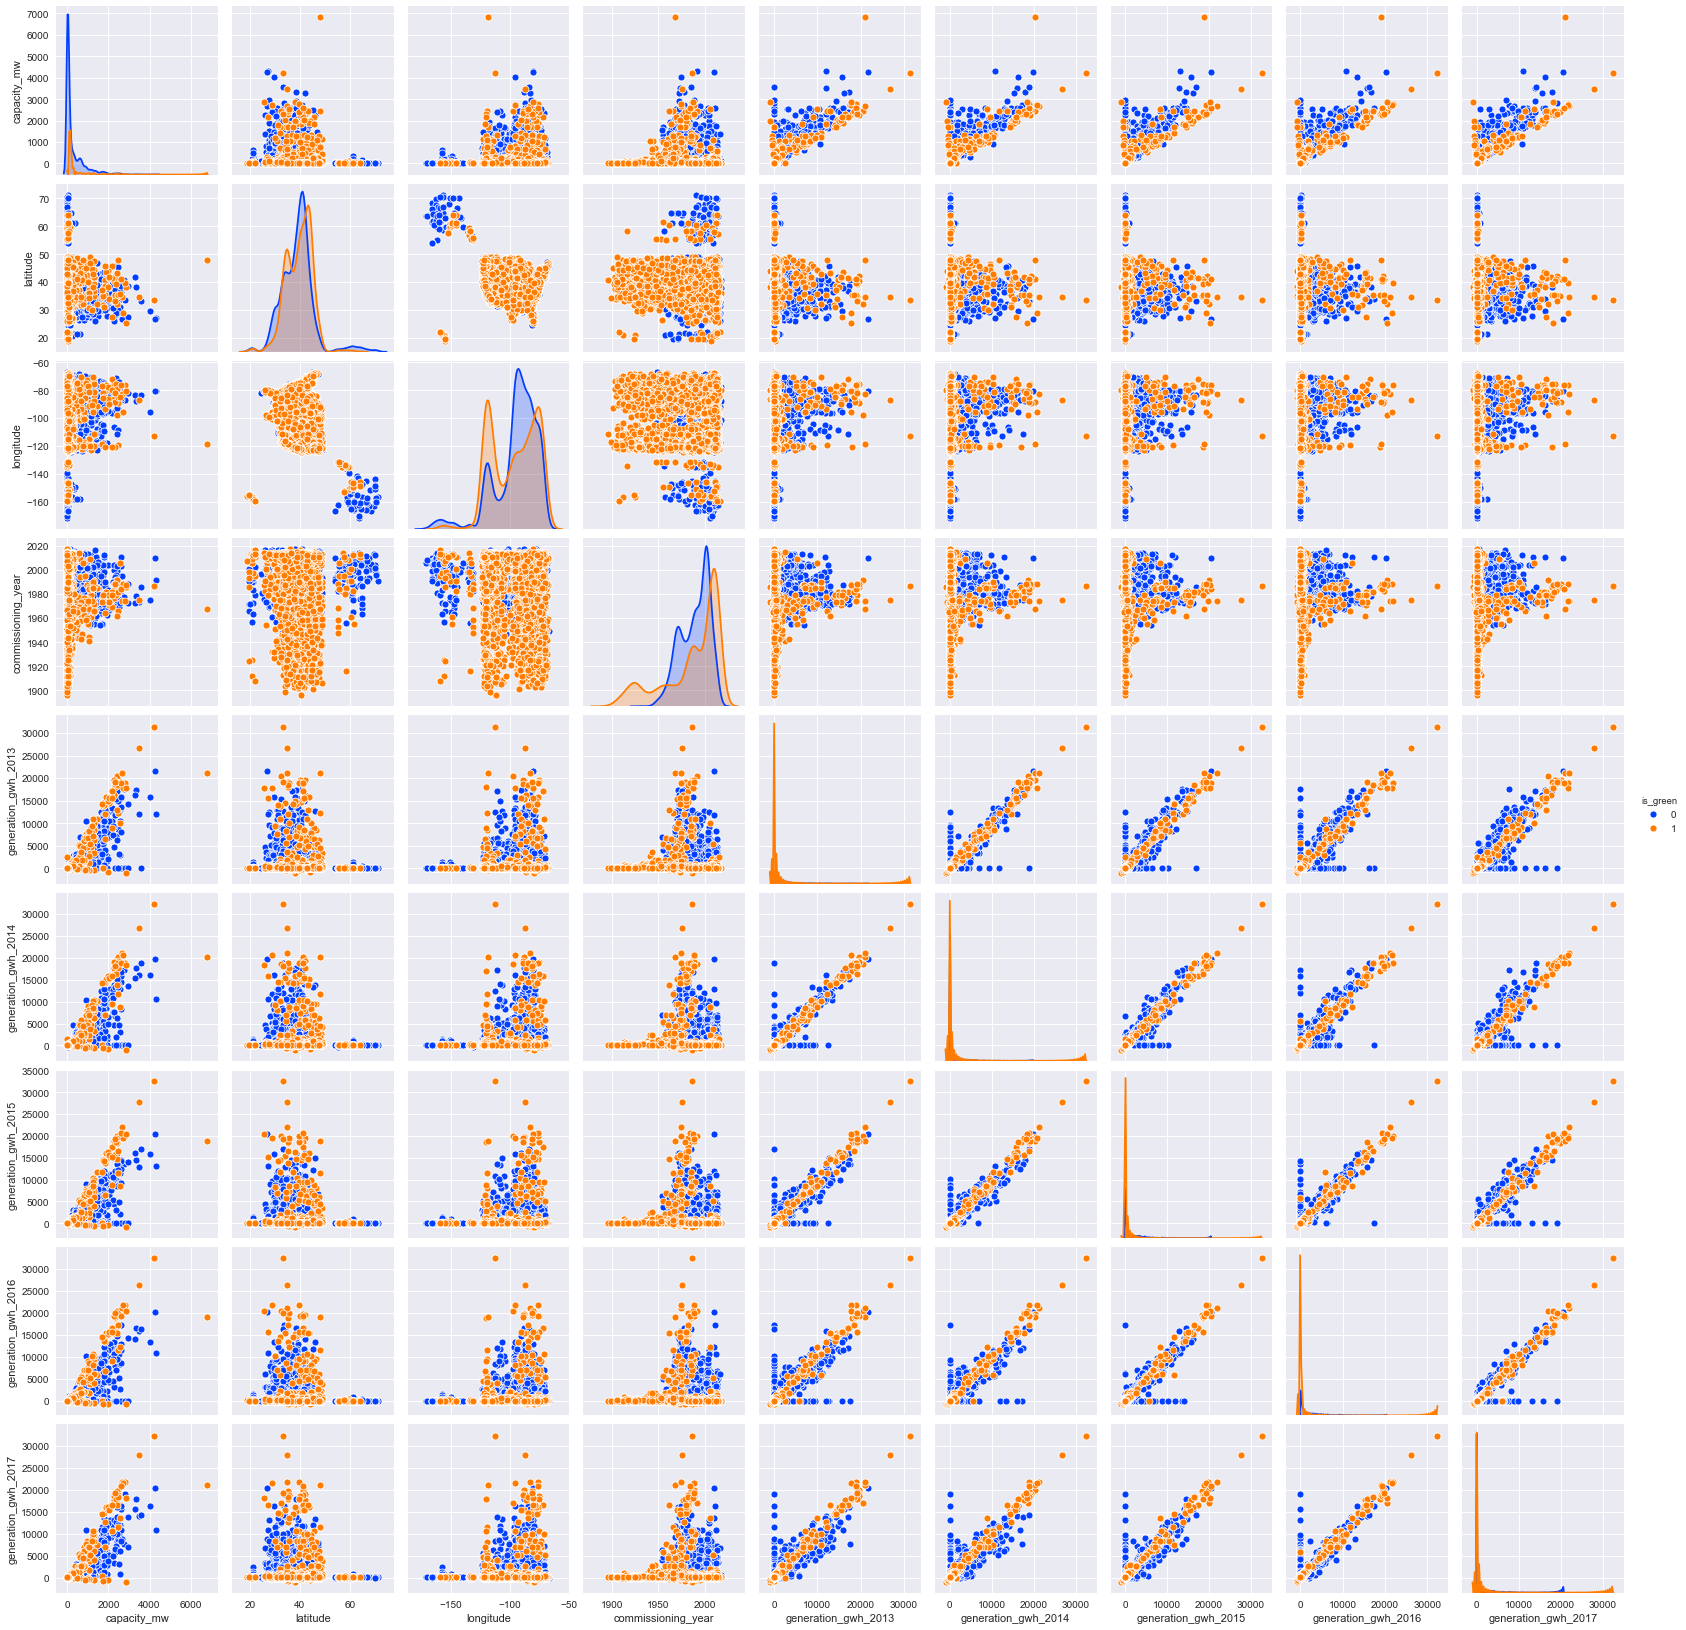

In [106]:
# Constructs a pairplot, similar to scatter matrix, to visualize the correlation with powerplants color coded by green, not green or other
seaborn.pairplot(df_US, hue = 'is_green', palette = 'bright')

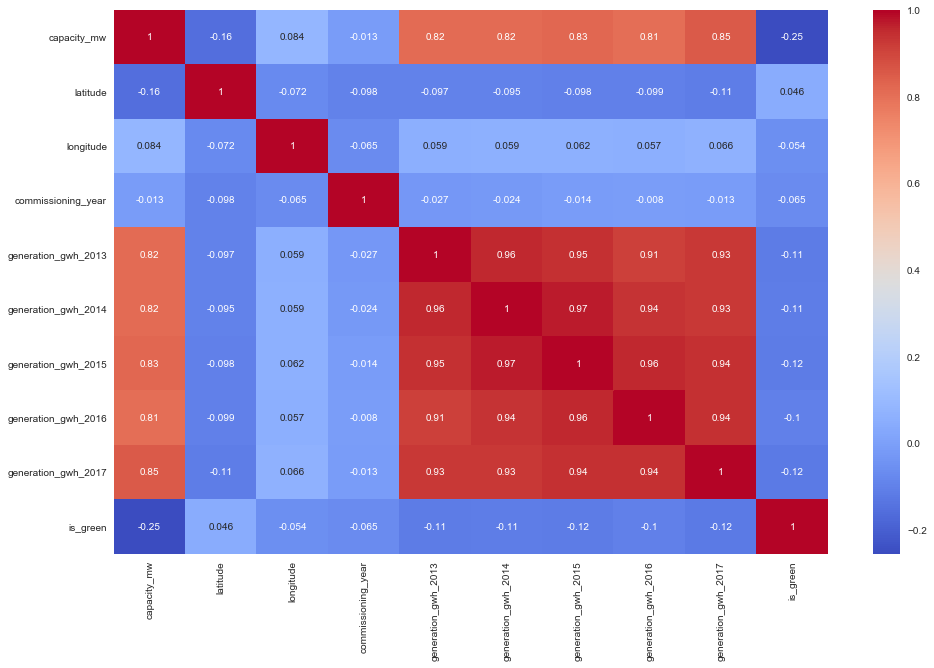

In [107]:
#Constructs a heatmap for correlation coefficient using seaborn
plt.figure(figsize = (16,10))
seaborn.heatmap(df_US.corr(), annot = True, cmap = "coolwarm")

**Interpretation:**

In the US, from the visualizations above, production capacity_mw and actual energy generation for years 2013-2017 seem to be highly correlated. And moreover, the energy generation year by year seem to be highly correlated with each other. So, in the next section we shall build a regression model for the year 2017 generation based on these correlated variables. 

### Regression Models
#### Simple linear models

In [ ]:
# Builds a simple linear model for energy generation 2017 based on production capacity_mw

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ capacity_mw", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2013

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2013", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2014

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2014", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2015

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2015", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2016

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2016", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

**Interpretation:**

In building the simple linear models for the US, we found out that for estimating the 2017 energy generation, the data from the 2015 had the highest R-squared coefficient among everyone at 0.892. However, for other years were also quite close, with 2016 being 0.890, 2013 being 0.864 and 2014 being 0.861. Contrary to our correlation matrix, the data for capacity_mw was not a particularly strong predictor for energy generation in 2017 with a R-squared coefficient of 0.728. So, to build a even stronger model, we try to build a multilinear regression model based on energy generation from 2013-2016. 

### Multilinear Regression model

In [78]:
# Builds a multilinear model for energy generation 2017 based on energy generated in years 2013-2016

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ capacity_mw + generation_gwh_2013 + generation_gwh_2014 + generation_gwh_2015 + generation_gwh_2016", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     generation_gwh_2017   R-squared:                       0.932
Model:                             OLS   Adj. R-squared:                  0.932
Method:                  Least Squares   F-statistic:                 1.700e+04
Date:                 Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                         15:28:36   Log-Likelihood:                -48228.
No. Observations:                 6244   AIC:                         9.647e+04
Df Residuals:                     6238   BIC:                         9.651e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -31.9230      7.557     -4.224      0.000     -46.738     -17.108
capacity_mw             0.9107      0.030     30.546      0.000       0.852       0.969
generation_gwh_2013     0.3207      0.012     26.427      0.000       0.297       0.345
generation_gwh_2014    -0.1399      0.017     -8.346      0.000      -0.173      -0.107
generation_gwh_2015     0.2125      0.018     11.738      0.000       0.177       0.248
generation_gwh_2016     0.4518      0.012     36.742      0.000       0.428       0.476
==============================================================================
Omnibus:                     8465.660   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8208175.456
Skew:                           7.170   Prob(JB):                         0.00
Kurtosis:                     180.042   Cond. No.                     4.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:**

Based on our simple linear models above, we built a multilinear regression model for predicting the energy generation in 2017 based on data from 2013-2016 and the production capacity_mw. And we have a very strong model with a R-squared coefficient of 0.932 meaning that this model will be useful for prediction. Next we use the cross validation method to find out the robustness of this model.

### Cross Validation

In [79]:


# Applying the cross validation method

X = df_US[['capacity_mw', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016']]
y = df_US["generation_gwh_2017"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) # 67% of data in training set, 33% in the test set
lr = LinearRegression()
lr.fit(X = X_train, y = y_train)
print ("Training accuracy: ",lr.score(X_train, y_train))
print ("Test accuracy: ", lr.score(X_test, y_test))

Training accuracy:  0.9348484994178727
Test accuracy:  0.9174855254588412


**Interpretation:**

Using cross validation, we see that our model can correctly predict 93.5% of the training set and 91.7% of the test dataset. This means that our multilinear regression model will correctly predict the dependent value in 91.7% of the points that were not used to train the model, which is quite good.

### Logistic Regression model

In [80]:
import statsmodels.api as sm

#Green fuels = 1, non-green fuels = 0, other = 0
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], 0))

df_US['is_green'] = df_US['primary_fuel'].apply(lambda x: green_map[x])

#Build a logistic regression model based on the following variables to predict whether a poweplant is green or not

x_train = df_US[['capacity_mw', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']] 
y_train = df_US[['is_green']] 
logit_reg = sm.Logit(y_train, x_train).fit()
print(logit_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.652294
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               is_green   No. Observations:                 6244
Model:                          Logit   Df Residuals:                     6238
Method:                           MLE   Df Model:                            5
Date:                Tue, 23 Mar 2021   Pseudo R-squ.:                 0.04639
Time:                        15:28:47   Log-Likelihood:                -4072.9
converged:                       True   LL-Null:                       -4271.1
Covariance Type:            nonrobust   LLR p-value:                 1.874e-83
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
capacity_mw            -0.0037      0.000    -16.098      0.000      -0.004      -0.003
ge

**Interpretation:**

We tried to build a logistic regression model to predict whether a given powerplant is green or not based on the variables capacity_mw and energy generated from 2013-2017. However, the model is not very good at predicting it. 


### Hypothesis testing - has there been an increase in energy output between years (2013-2017) in the US?

In [81]:
df_US1 =df_US[["generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
df_US1.describe()

generation_gwh_2013  generation_gwh_2014  generation_gwh_2015  \
count          6244.000000          6244.000000          6244.000000   
mean            576.499422           569.110502           577.240897   
std            2079.502035          2079.797372          2049.724535   
min            -947.600000          -989.619000          -864.428000   
25%               1.738500             2.155750             2.022500   
50%              21.357500            20.787000            20.599000   
75%             185.301499           177.918500           182.001000   
max           31431.080000         32320.917000         32525.595000   

       generation_gwh_2016  generation_gwh_2017  
count          6244.000000          6244.000000  
mean            554.631885           607.436558  
std            2019.451285          2093.437107  
min            -768.620000          -934.944000  
25%               1.905500             3.724250  
50%              19.981795            29.531500  
75%             178.971750           223.098250  
max           32377.477000         32340.138000

#### Boxplot

Text(0, 0.5, 'Energy output (in GWh)')

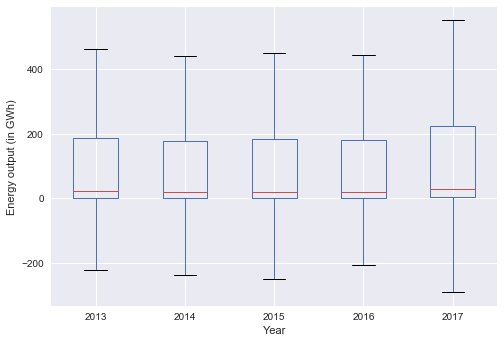

In [82]:
# Draws a boxplot for energy generation between 2013 -2017
df_US1.boxplot(showfliers=False)
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Interpretation:**

There does not really seem to be an increase in output between 2013 and 2014 since the mean has decreased. For 2014-15, there seems to be an increase in average generation, which we shall investigate. And similarily, there seems to be an increase in average energy generation between 2016-17, shown also in the boxplot. This too, we shall investigate. 

#### T-tests - Investigating year by year change

In [83]:
# conducts a t-test to investigate difference in energy generation between 2014 and 2015

t1, pval1 = ttest_ind(df_US1["generation_gwh_2014"],df_US1["generation_gwh_2015"])
print(t1, pval1)

-0.22001219475994913 0.8258652541525644


In [84]:
# conducts a t-test to investigate difference in energy generation between 2016 and 2017

t2, pval2 = ttest_ind(df_US1["generation_gwh_2016"],df_US1["generation_gwh_2017"])
print(t2, pval2)

-1.4345035260952157 0.1514536681591239


**Interpretation:**

Our t-tests indicate that there has not really been a increase in output between 2014 and 2015 as can be seen by the p-value which is quite high. The average increase might be because of randomness. However, for the years 2016 and 2017, the case is rather interesting. As seen by increase in mean, the t-test shows that if we take a significance level of 5%, the p-value is greater meaning that the difference is not statistically significant. However, at a signifance level of 10 or 15%, the difference is statistically significant. So, we cannot just rule out the difference as occuring because of random chance. 

In [85]:
#Returns a pivot table containing the absolute change per year in energy generation between states
def abs_change_per_state(df_US):
    
    values = ['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']

    pt = pd.pivot_table(df_US,index=["us_state"], values=values, aggfunc=np.sum)
    
    pt['2013'] = abs(pt['generation_gwh_2013'] - pt['generation_gwh_2013'])
    pt['2014'] = abs(pt['generation_gwh_2014'] - pt['generation_gwh_2013'])
    pt['2015'] = abs(pt['generation_gwh_2015'] - pt['generation_gwh_2014'])
    pt['2016'] = abs(pt['generation_gwh_2016'] - pt['generation_gwh_2015'])
    pt['2017'] = abs(pt['generation_gwh_2017'] - pt['generation_gwh_2016'])
    
    
    return pt, pt[['2013','2014', '2015','2016','2017']]

In [86]:
_, pt = abs_change_per_state(df_US)
pt

2013          2014          2015          2016          2017
us_state                                                                      
Alabama            0.0   7259.746486   7994.330087  14328.395463  28011.882559
Alaska             0.0    806.117521    288.306068    365.655540    754.851096
Arizona            0.0  10621.083562   1665.489928   2600.326679   1818.280747
Arkansas           0.0    412.359676   7246.890672   5673.570212   1616.118387
California         0.0   3571.944280   2770.705393   7418.700286  12500.857807
Colorado           0.0    987.085476   2216.850327    459.130168     25.072872
Connecticut        0.0   1102.859546  11468.140352    662.649142   1324.460950
Delaware           0.0   2437.181864   5732.093761   3219.879869   2613.426109
Florida            0.0  19003.175069   1901.947698   3745.105118  75131.840315
Georgia            0.0  19929.079832   4587.199215  20234.313234   4446.903735
Hawaii             0.0    361.419856    161.628211     61.893835   2923.316187
Idaho              0.0    367.187165    204.401164    348.398591   3278.643563
Illinois           0.0  22470.882897   1676.914942  17780.136493  33358.131056
Indiana            0.0   6625.007689   7746.188424   9679.286353   6412.328571
Iowa               0.0   2059.866250    967.695923   4159.645007   2305.783535
Kansas             0.0    133.276462   4078.052532    490.622937   1277.452832
Kentucky           0.0   1807.696345    286.033065  13861.817904   1538.870201
Louisiana          0.0   1846.776849   7911.009444    130.719374   5128.676916
Maine              0.0   1854.084616   1783.781004    634.513130    830.355073
Maryland           0.0    618.335196    458.514094   5215.338601   2472.069842
Massachusetts      0.0   1436.022702   1146.717188    705.082579   3678.888725
Michigan           0.0   2684.243995  13882.732281   2518.883231   6897.227386
Minnesota          0.0   4172.656582    822.382804   2571.649091   8141.942599
Mississippi        0.0   2327.322662   6180.247150   5177.028749   2844.335501
Missouri           0.0   7572.543152   2315.457601   5134.296888   8325.827361
Montana            0.0   2856.506663    548.519286   1391.356977    361.415401
Nebraska           0.0    784.517235   2014.344351    879.047896   7870.006782
Nevada             0.0   5363.913978   8889.225502      2.016529   2676.986649
New Hampshire      0.0    551.783062    259.452952     62.222991   1413.278761
New Jersey         0.0   3676.384895   2397.187367    819.515988   6058.633169
New Mexico         0.0     40.509028  11251.591031   8428.823221   7021.048674
New York           0.0    907.755848    487.417556   6612.858552   9683.089012
North Carolina     0.0   8483.704959   2474.378367   4319.734150  11164.321739
North Dakota       0.0    534.920560    568.873994     66.964847   9535.507570
Ohio               0.0   1261.897326   1058.568118   2036.756732   2370.350958
Oklahoma           0.0  12261.766048  11844.841260   2110.551088   3271.433040
Oregon             0.0   1802.579867   5629.195136   4120.039189    252.899018
Pennsylvania       0.0   3010.176166   6061.901088  25082.049970  21432.272081
Rhode Island       0.0     14.861366    421.493663    140.116895    785.460053
South Carolina     0.0    430.630957   2037.099262  18188.116635  20907.878396
South Dakota       0.0   1639.487260    305.713240    680.087800    700.051120
Tennessee          0.0    123.209933   3235.270809   4142.278837   1025.790640
Texas              0.0    178.233793   2675.431268   4721.905346   1130.108875
Utah               0.0   2295.571338   1954.504948   4271.384313   1689.215050
Vermont            0.0      5.485000     31.018530    146.190380    511.286285
Virginia           0.0   1979.978239    462.045484   3642.572913  10565.801914
Washington         0.0   2203.290001    907.550020   5199.869009   6085.016166
Washington, D.C.   0.0      0.000000     22.751000      0.922000      3.969000
West Virginia      0.0   1294.168399   8961.740419   9993.276262  14